In [1]:
import pygmt
import imageio
import numpy as np
import pandas as pd 
import xarray as xr

# Evaluation of major drainage systems

![sedflux](img/sedflux.png)

Here we design a workflow to extract for each time step the characteristics of each catchment in terms of sediment and water fluxes. The operation is performed globally.

> To avoid having to read the large netcdf file at each time step, we first create a new set of netcdf files with only required variables for the analysis 

In [167]:
# Specify the folder containing the netcdf file from our simulation
out = 'export/unconstrained/'

# Loop over each file and drop unwanted variables
for k in range(95,-5,-5):
    
    # Open the netcdf file
    dataset = xr.open_dataset(out+'data'+str(k)+'Ma.nc')
    
    # Drop some variables (we only keep the sediment flow fluxes and the basin indices)
    reduce_ds = dataset.drop_vars(names=['elevation','erodep','precipitation','fillDischarge','uplift'])
    
    # Save the reduced dataset as a new smaller netcdf
    reduce_ds.to_netcdf(out+'fsdata'+str(k)+'Ma.nc')

We can then use the function `getCatchmentInfo.py` to extract for each individual catchment the maximum fluxes. 

This operation especially when performed globally and over all time steps is pretty slow. The good news is that it is pretty much embarrassingly parallel so we will take advantage of this.

On USYD HPC computer you could install the required library to run it on multiple CPUs by using the following: 

```bash
module load gcc/4.9.3 python/3.6.5 petsc-gcc-mpich/3.11.1
pip install xarray netCDF4
```

A `PBS` script is also provided `fluxes.pbs` to show how to run it on HPC (it take about 10 minutes on 128 cores... much more on a local machine).

If you want to run it locally you can uncomment the following line and run it on 8 cpus (if you actually have 8 cpus on your machine)

In [61]:
#!mpirun -np 8 python3 getCatchmentInfo.py -i inputSedFlow.csv -o flowsed_model6

The script takes an input file `inputSedFlow.csv` that contains 2 columns: 

+ the first one if the time in Ma and
+ the second is the netcdf file (created above) for each specified time interval.

# Extract fluxes (sediment and flow)


Once finished, you will have 2 `csv` files per time step (one for the water discharge and one for the sediment fluxes). Each file contains 4 columns:

+ the first one is the basin index,
+ the second and third ones are the position of the outlet (longitude and latitude respectively),
+ the last column is the corresponding discharge or flux value.

In [204]:
# Pick a time in Ma needs to be a integer
step = 50

# Get the fluxes files 
flowdf = pd.read_csv(out+'flow'+str(step)+'.csv')
seddf = pd.read_csv(out+'sed'+str(step)+'.csv')

We will use the logarithmic values 

In [205]:
logFA = np.log10(flowdf['val'].values)
logSed = np.log10(seddf['val'].values)

Let's say we want to take the nth-largest values. To do so, we will first sort the values

In [206]:
sorted_index_array = np.argsort(logFA)
sortedFA = logFA[sorted_index_array]
sortedLon = flowdf['lon'].values[sorted_index_array]
sortedLat = flowdf['lat'].values[sorted_index_array]

sorted_index_array1 = np.argsort(logSed)
sortedSed = logSed[sorted_index_array1]
sortedLon1 = seddf['lon'].values[sorted_index_array1]
sortedLat1 = seddf['lat'].values[sorted_index_array1]

We now want to visualise the main fluxes, for example we will look at the 100 largest fluxes:

In [207]:
# Define nth values
nlargest = 100

rLon = sortedLon[-nlargest : ]
rLat = sortedLat[-nlargest : ]
rFA = sortedFA[-nlargest : ]

rLon1 = sortedLon1[-nlargest : ]
rLat1 = sortedLat1[-nlargest : ]
rSed = sortedSed[-nlargest : ]

## Plot for flow

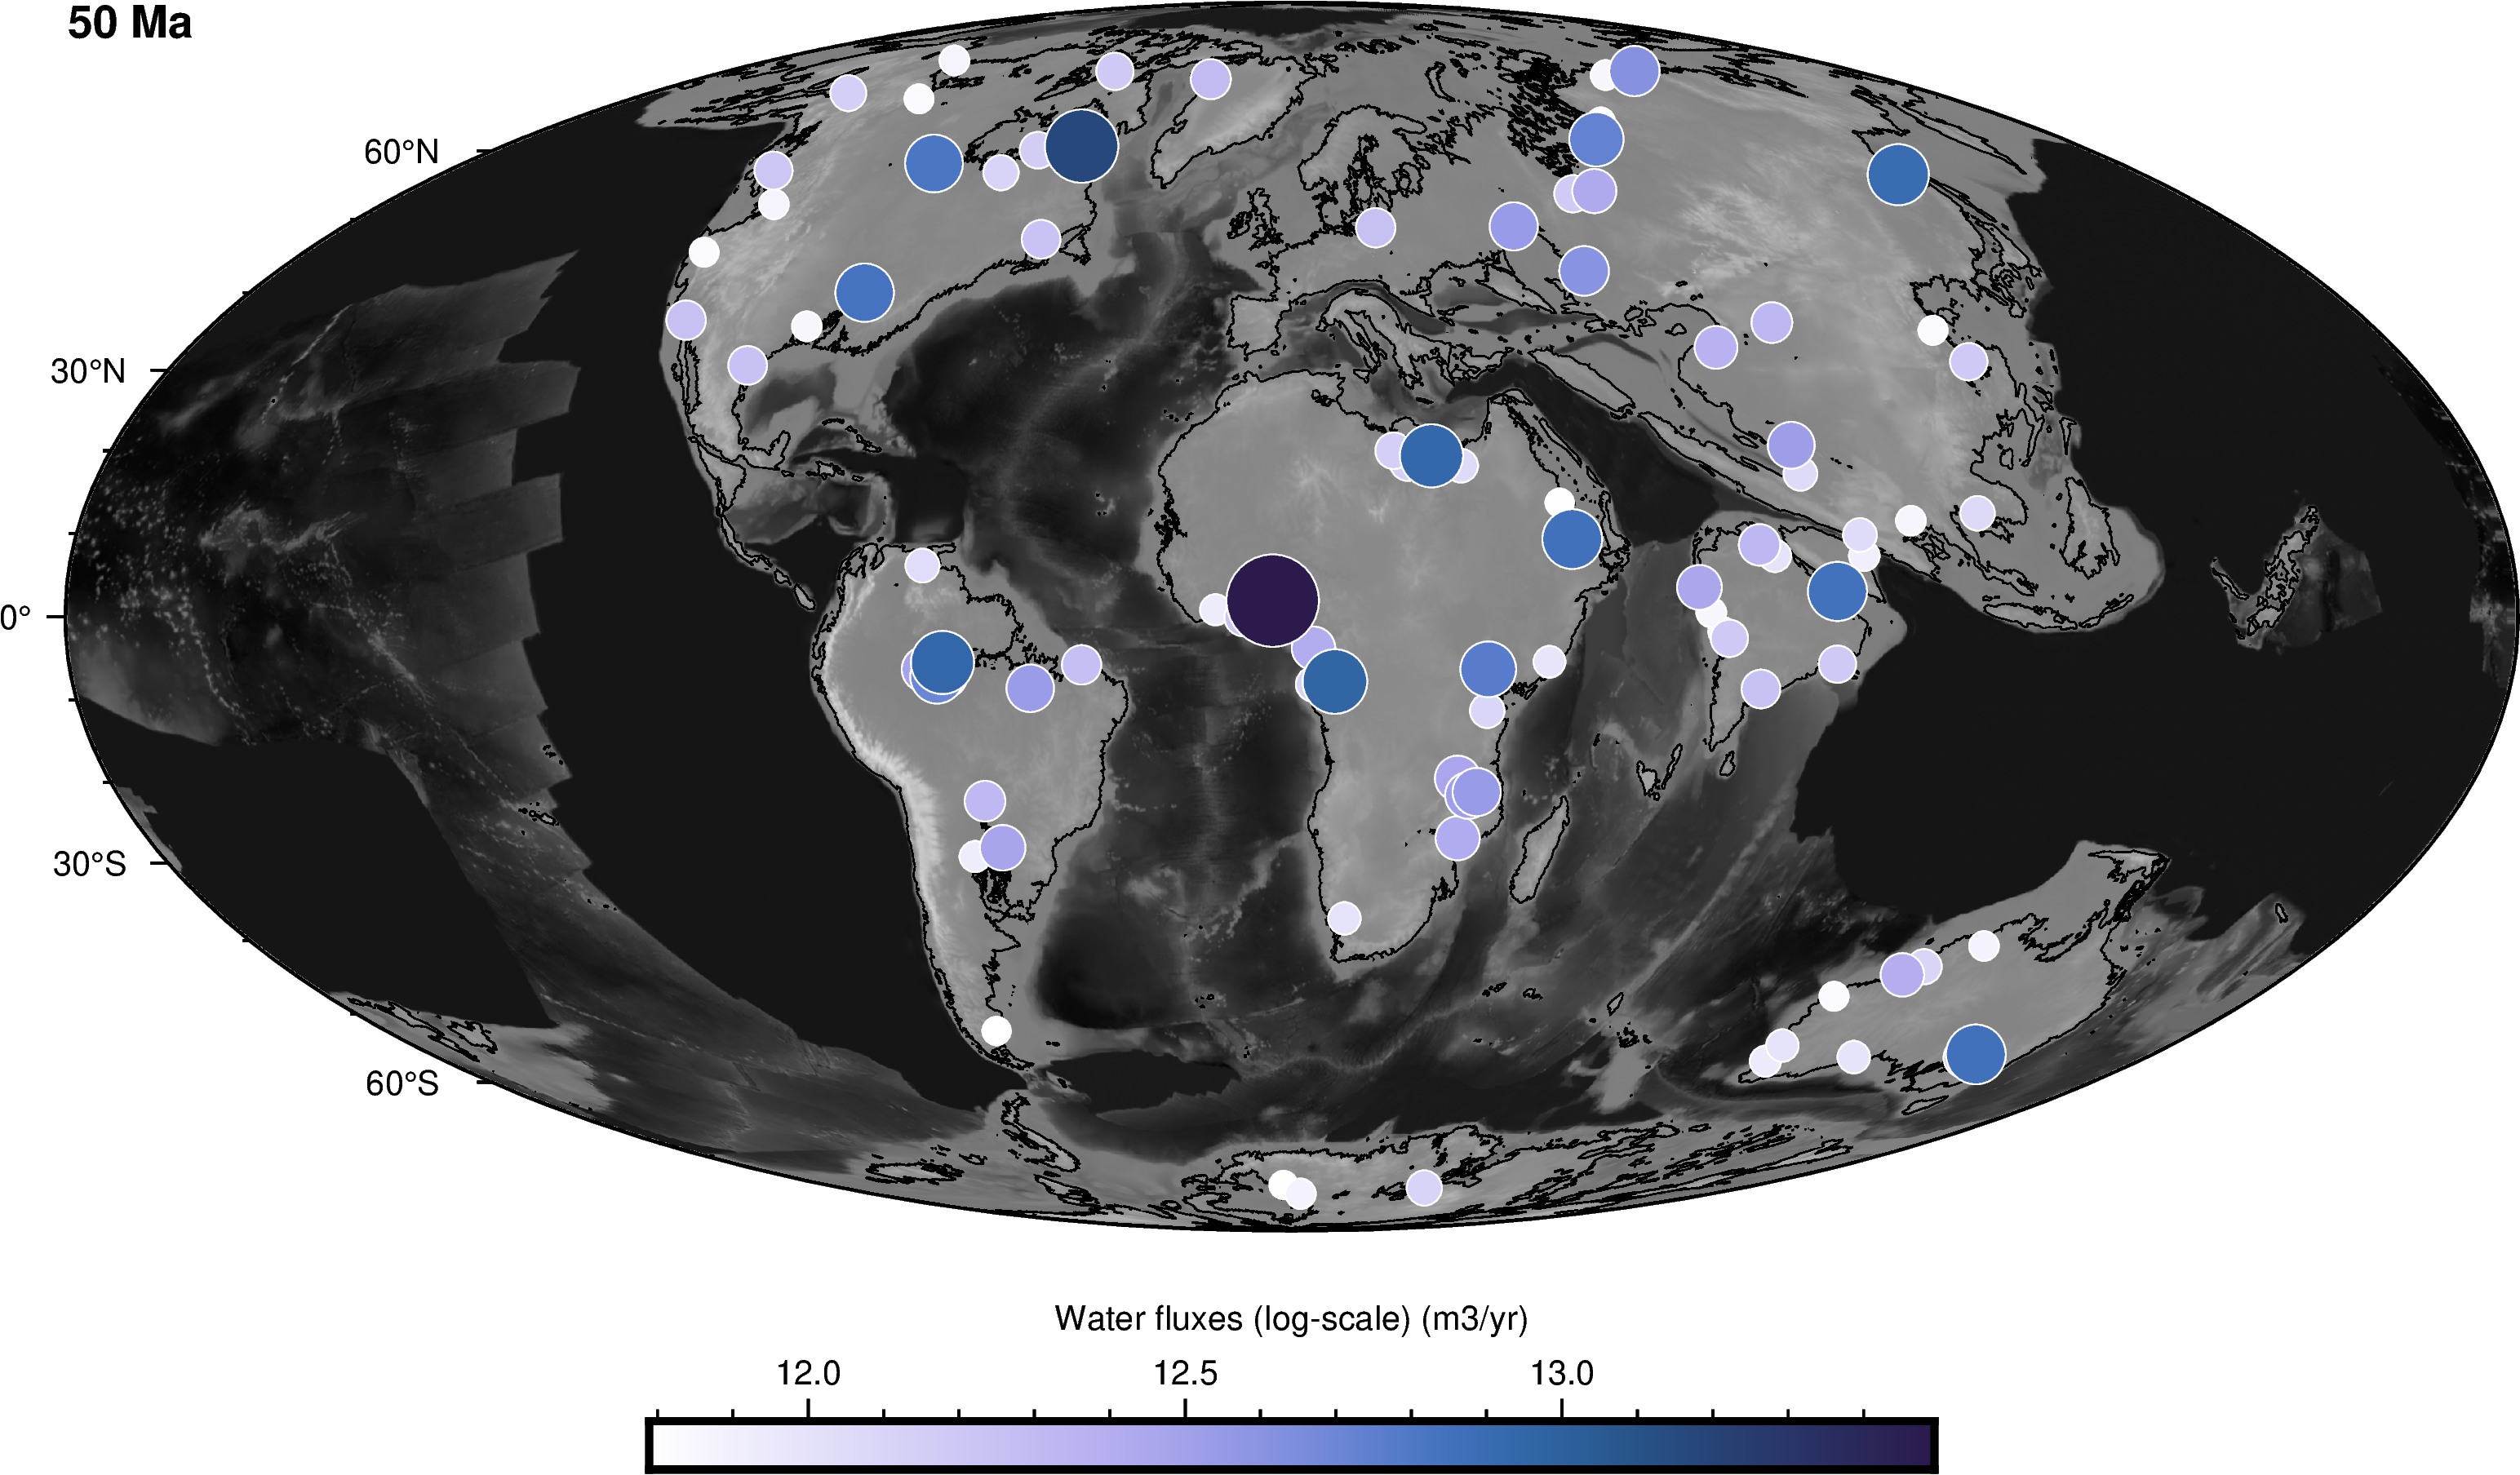

In [214]:
# Let read the initial dataset (this will be used to get the elevation on our plot)
dataset = xr.open_dataset(out+'data'+str(step)+'Ma.nc')


fig = pygmt.Figure()

# Background image
with pygmt.config(FONT='6p,Helvetica,black'):
    pygmt.makecpt(cmap="gray", series=[-6000, 6000])
    fig.basemap(region='d', projection='W6i', frame='afg')
    fig.grdimage(dataset.elevation, shading='+a345+nt1+m0', frame=False)
    
    fig.grdcontour(
        interval=0.1,
        grid=dataset.elevation,
        limit=[-0.1, 0.1],
    )

# Scatter plot
with pygmt.config(FONT='6p,Helvetica,black'):
    pygmt.makecpt(cmap="devon", series=[rFA.min(), rFA.max()], reverse=True)

    fig.plot(
        x=rLon,
        y=rLat,
        style="cc",
        pen="white",
        size=0.00005 * 2 ** rFA,
        color=rFA,
        cmap=True,
    )

    fig.colorbar(position="jBC+o0c/-1.5c+w8c/0.3c+h", 
                 frame='af+l"Water fluxes (log-scale) (m3/yr)"')

# Time interval
fig.text(text=str(step)+" Ma", position="TL", font="8p,Helvetica-Bold,black")

fig.show(dpi=500, width=1000)
fname = 'fluxes/model6/flow'+str(step)+'Ma.png'
fig.savefig(fname=fname,dpi=500)

## Plot for sed

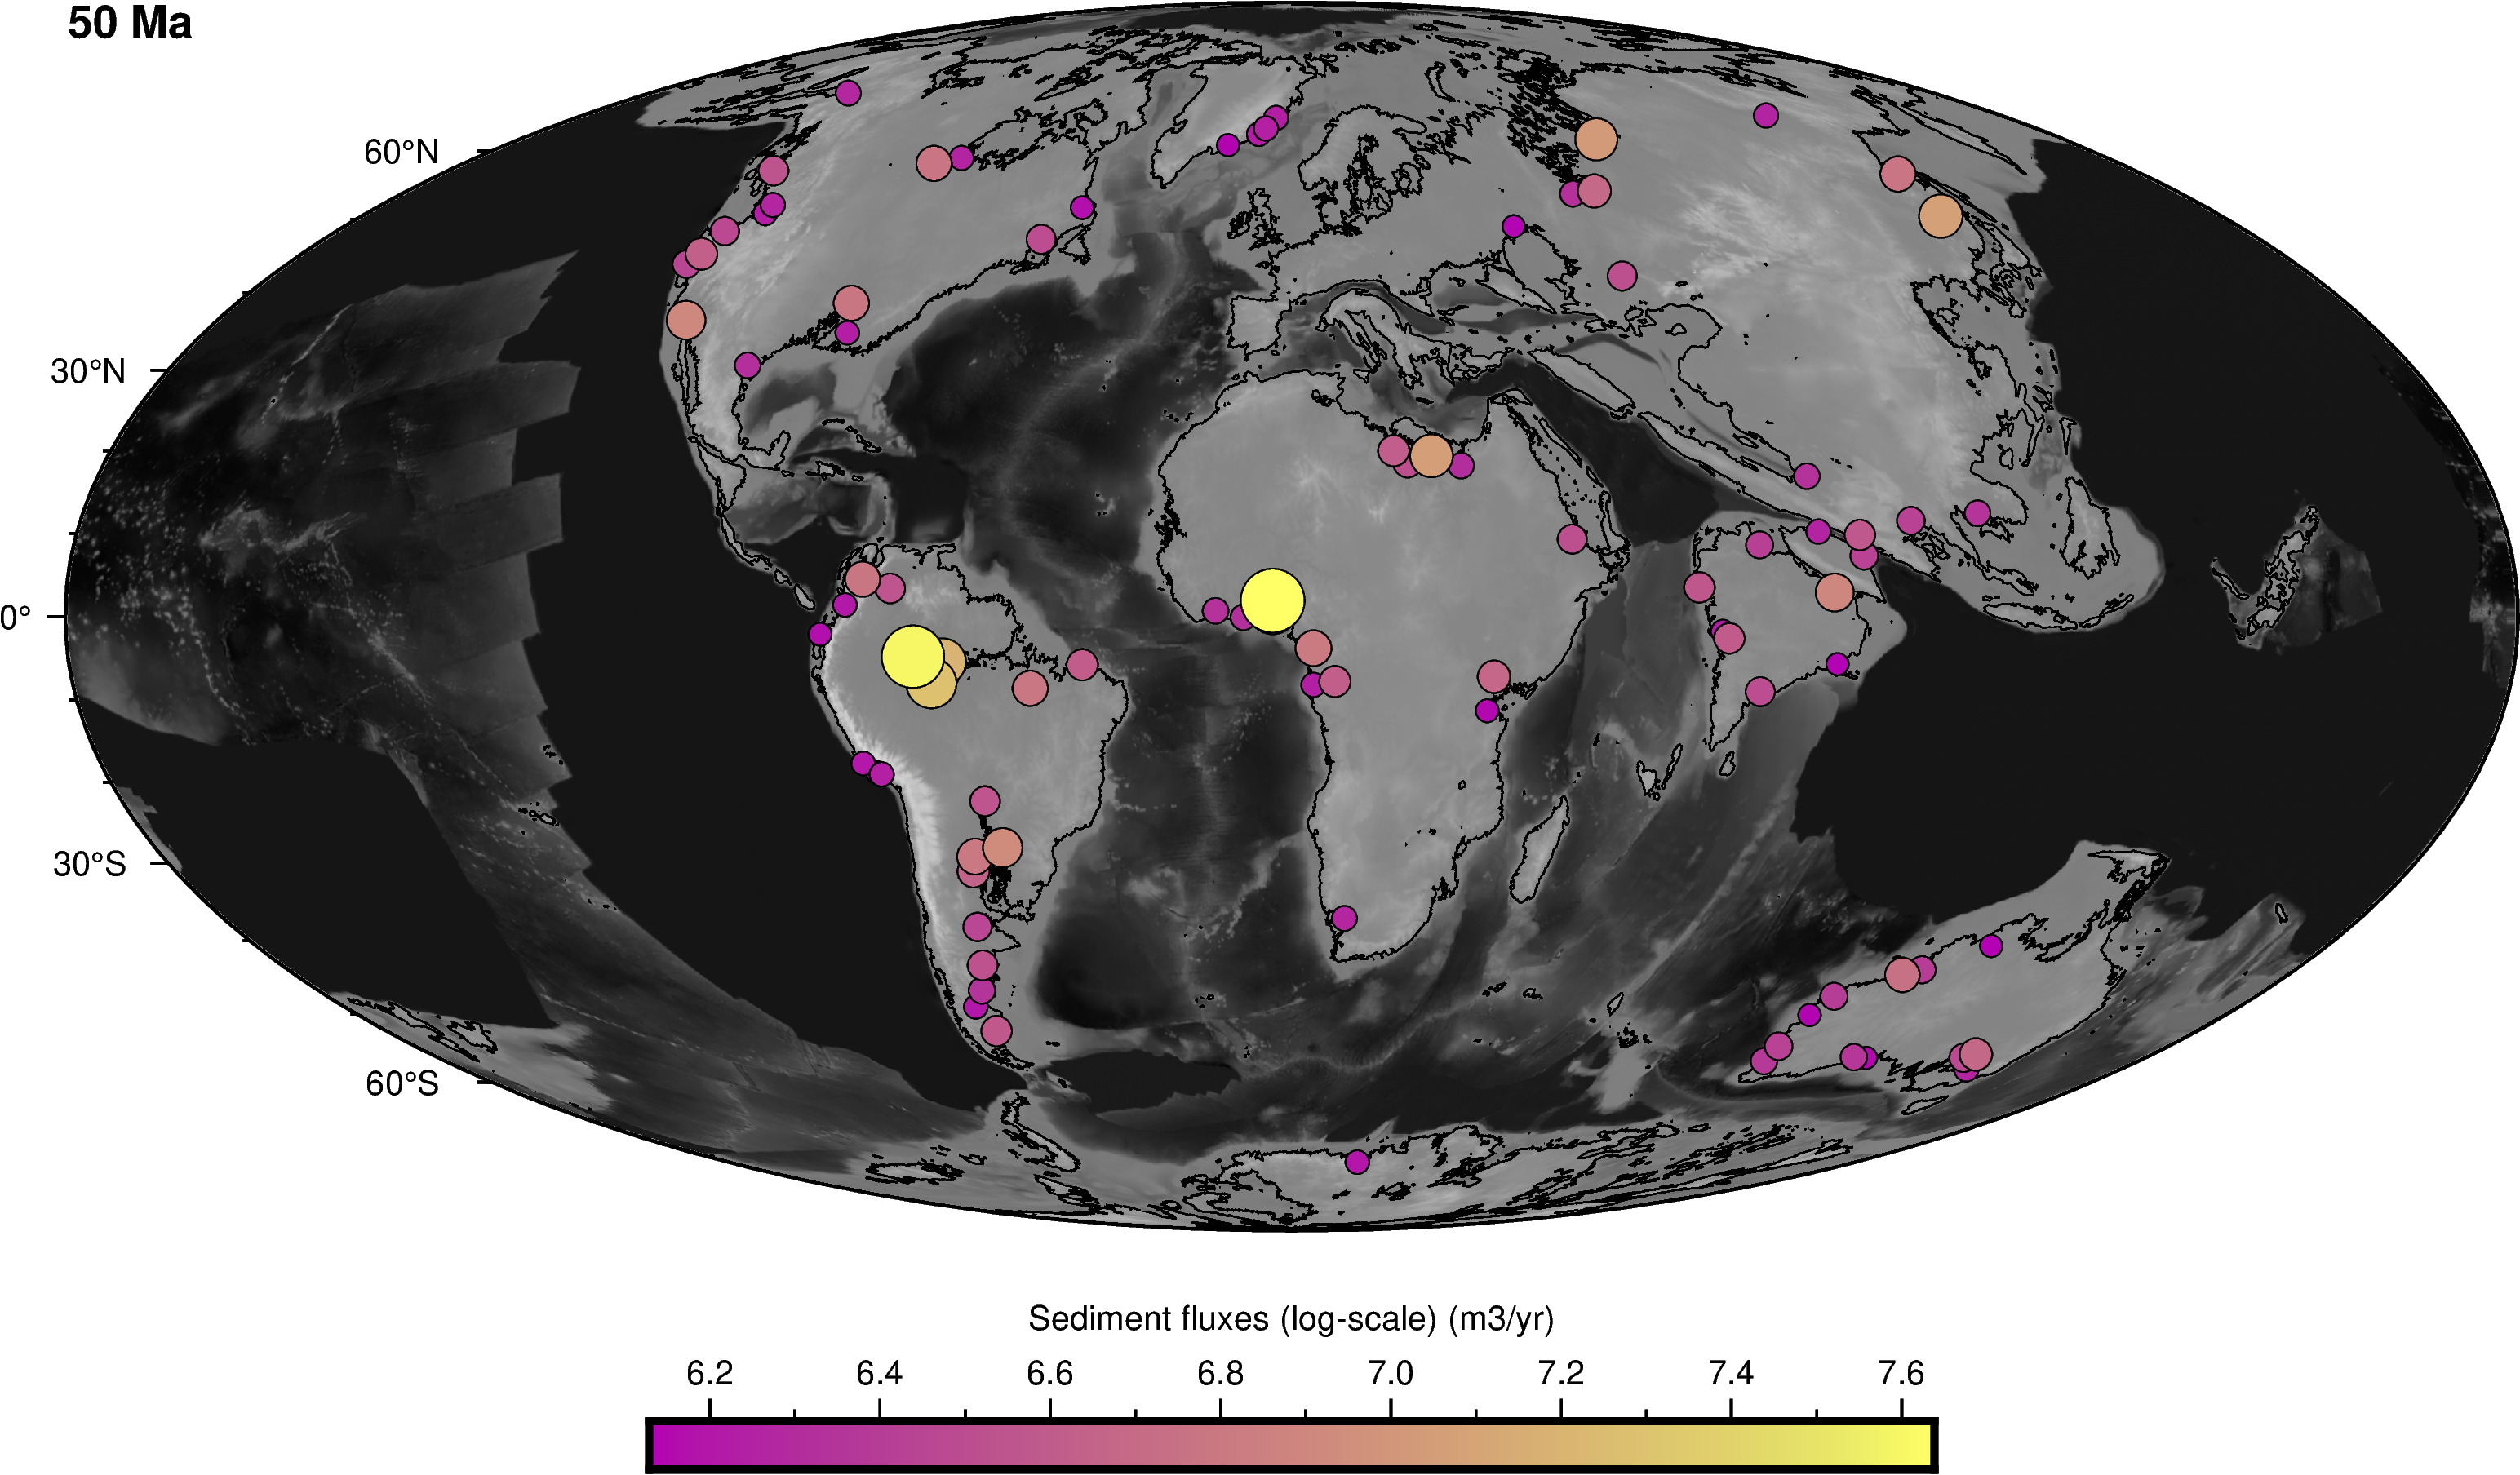

In [212]:
fig = pygmt.Figure()

# Background image
with pygmt.config(FONT='6p,Helvetica,black'):
    pygmt.makecpt(cmap="gray", series=[-6000, 6000])
    fig.basemap(region='d', projection='W6i', frame='afg')
    fig.grdimage(dataset.elevation, shading='+a345+nt1+m0', frame=False)
    
    fig.grdcontour(
        interval=0.1,
        grid=dataset.elevation,
        limit=[-0.1, 0.1],
    )

# Scatter plot
with pygmt.config(FONT='6p,Helvetica,black'):
    pygmt.makecpt(cmap="buda", series=[rSed.min(), rSed.max()])
    fig.plot(
        x=rLon1,
        y=rLat1,
        style="cc",
        pen="black",
        size=0.002 * 2 ** rSed,
        color=rSed,
        cmap=True,
    )
    fig.colorbar(position="jBC+o0c/-1.5c+w8c/0.3c+h", 
                 frame='af+l"Sediment fluxes (log-scale) (m3/yr)"')

# Time interval
fig.text(text=str(step)+" Ma", position="TL", font="8p,Helvetica-Bold,black")

fig.show(dpi=500, width=1000)
fname = 'fluxes/model6/sed'+str(step)+'Ma.png'
fig.savefig(fname=fname,dpi=500)